# <center>Проект построения ML модели классификации звуков</center>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score, \
    classification_report, confusion_matrix
from sklearn.decomposition import PCA
import os
from wave import open as open_wave
import IPython
import librosa
import librosa.display
from scipy.io import wavfile
import os, random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## <center>Сэмпл классифицируемых звуков

In [3]:
sr = 44100
x = "Dolphine/" + random.choice(os.listdir("Dolphine"))
y = "Horse/" + random.choice(os.listdir("Horse"))
IPython.display.display(IPython.display.Audio(x, rate = sr))
IPython.display.display(IPython.display.Audio(y, rate = sr))

## <center>Создаем датафрейм

In [4]:
all_res = []
def sound(waveFile, a):
    nframes = waveFile.getnframes()
    wavFrames = waveFile.readframes(nframes)
    sound = np.frombuffer(wavFrames, dtype=np.int16)
    lst = list(sound)
    if a == 'Dolphine':
        lst.insert(0, 1)
    else:
        lst.insert(0, 0)
    sound = np.asarray(lst)
    data_frame = pd.DataFrame(sound.reshape(1,-1))
    all_res.append(data_frame)
    
for file in os.listdir('Dolphine'):
    waveFile = open_wave(f'Dolphine\{file}','rb')
    sound(waveFile, 'Dolphine')
    
for file in os.listdir('Horse'):
    waveFile = open_wave(f'Horse\{file}','rb')
    sound(waveFile, 'Horse')
    
data = pd.concat(all_res, ignore_index = True)
list_nan = data.columns[data.isna().any()].tolist()
data = data.iloc[: , :list_nan[0]]
wave_data = data.sample(frac=1).reset_index(drop=True)

In [5]:
wave_data

,0,1,2,3,4,5,6,7,8,9,...,79572,79573,79574,79575,79576,79577,79578,79579,79580,79581
0,0,105,145,110,144,93,130,77,110,71,...,-1112,-415,-366,341,400,523,570,943,1003,1613
1,0,27,62,26,59,19,56,15,45,7,...,3249,2220,1639,1117,1000,63,-313,-1091,-1449,-1953
2,1,16,16,-7,-7,-39,-38,-47,-49,-27,...,-133,-109,-125,-118,-77,-101,-50,-64,-18,-20
3,0,-55,-48,-43,-38,-25,-27,-19,-26,-24,...,-32,-23,-19,-8,-9,8,5,32,23,57
4,1,3,3,-1,0,-5,-6,-4,-4,-12,...,-1408,-1104,-1103,-1035,-1037,-1268,-1267,-1504,-1503,-1270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,112,138,137,128,119,122,93,119,79,...,-3291,-4588,-3509,-4648,-3569,-4640,-3509,-4633,-3487,-4667
96,0,65,112,-38,6,-162,-113,-318,-275,-368,...,824,484,410,-226,-252,-1576,-694,-2132,-1676,-2078
97,0,-211,-211,-285,-283,-284,-283,-333,-333,-395,...,15,-39,18,-28,24,-34,19,-36,12,-32
98,0,-151,-155,-137,-134,-115,-116,-94,-91,-76,...,-710,-418,-425,-15,-10,446,444,827,828,1000


## <center> Сохраним данные

In [7]:
wave_data.to_csv('wave_data.csv', index=False)

## <center>Разделим данные на features и label

In [6]:
wave_label = wave_data[0]
wave_features = wave_data.drop([0], axis=1)
wave_label.shape, wave_features.shape

((100,), (100, 79581))

## <center> Снизим размерность для отображения

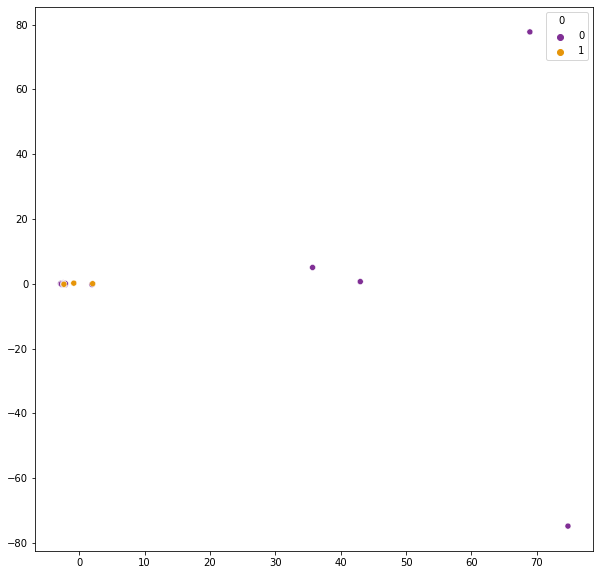

In [7]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(wave_features.to_numpy())
data_scaled = pd.DataFrame(data_scaled)
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=pca_transformed[:, 0], 
    y=pca_transformed[:, 1], 
    hue=wave_label.astype(int), 
    palette="CMRmap",
    legend='full'
);

## <center> Разделяем данные на тест и трэйн

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(
    wave_features,
    wave_label,
    test_size=0.33,
    stratify=wave_label,
    random_state=42)

## <center> Выделим функции для Train-test-split, Kfold и графического отображения

In [9]:
def tts(model):
    x_train = X_train
    x_test = X_test
    y_train = Y_train
    y_test = Y_test
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _tresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test,y_pred))

In [157]:
def kf(model):
    kf = KFold(n_splits=5, shuffle = True)
    result = next(kf.split(features), None)
    x_train = features.iloc[result[0]]
    x_test = features.iloc[result[1]]
    y_train = label.iloc[result[0]]
    y_test = label.iloc[result[1]]
    model.fit(x_train, y_train)
    y_pred = cross_val_predict(model, x_test, y_test, cv=2)
    acc_list.append(accuracy_score(y_test, y_pred))
    fpr, tpr, _tresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr), 2))
#     cm_list.append(confusion_matrix(y_test,y_pred)) 

In [68]:
def crossval(model):
    x_train = X_train
    x_test = X_test
    y_train = Y_train
    y_test = Y_test
    model.fit(x_train, y_train)
    accuracy = cross_val_score(model, x_test, y_test, scoring = 'accuracy', cv=10).mean()
    auc_score = cross_val_score(model, x_test, y_test, scoring = 'roc_auc', cv=10).mean()
    y_pred = cross_val_predict(model, x_test, y_test, cv=cv)
    acc_list.append(accuracy)
    auc_list.append(round(auc_score, 2))
    cm_list.append(confusion_matrix(y_test,y_pred)) 

In [13]:
def pairplot(cm, model):
    if len(cm_list)%2!=0:
        sub = fig.add_subplot(2, 4, i+1).set_title(model)
    else:
        sub = fig.add_subplot(2, 3, i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True,cmap = 'Blues_r')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')

## <center> Добавляем методы классификации

In [104]:
model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(KNeighborsClassifier(n_neighbors=2))
model_pipeline.append(linear_model.RidgeClassifier())
model_list = ['LogisticRegression', 'SVC', 'DecisionTreeClassifier',  'KNeighborsClassifier', 'RidgeClassifier']


# <center>Поехали

In [15]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(model_pipeline, every = 1):
    tts(model)    

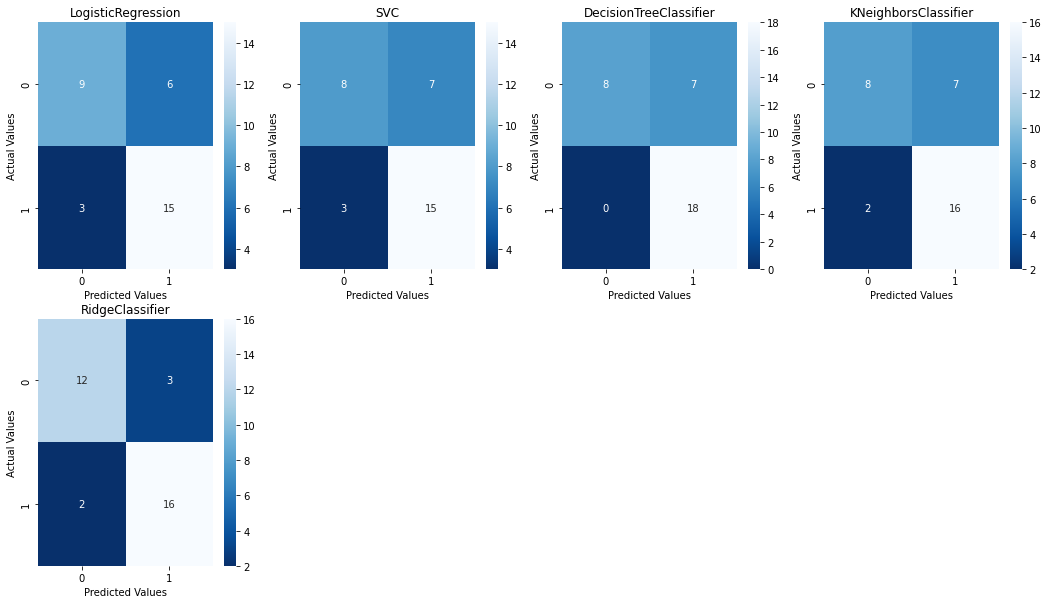

In [20]:
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    pairplot(cm, model)    

In [21]:
result_TTS_CLS = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_TTS_CLS

,Model,Accuracy,AUC
0,LogisticRegression,0.727273,0.72
1,SVC,0.696970,0.68
2,DecisionTreeClassifier,0.787879,0.77
3,KNeighborsClassifier,0.727273,0.71
4,RidgeClassifier,0.848485,0.84


## <center>Градиентный бустинг

In [150]:
gbs_pipeline = []
gbs_pipeline.append(GradientBoostingClassifier(n_estimators=1))
gbs_pipeline.append(XGBClassifier(n_estimators=50))
gbs_pipeline.append(CatBoostClassifier(iterations=50, logging_level='Silent'))
gbs_pipeline.append(LGBMClassifier(n_estimators=50))
gbs_pipeline.append(RandomForestClassifier(n_estimators=50))
gbs_list = ['GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier', 'LGBMClassifier', 'RandomForestClassifier']

In [23]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(gbs_pipeline, every = 1):
    tts(model)

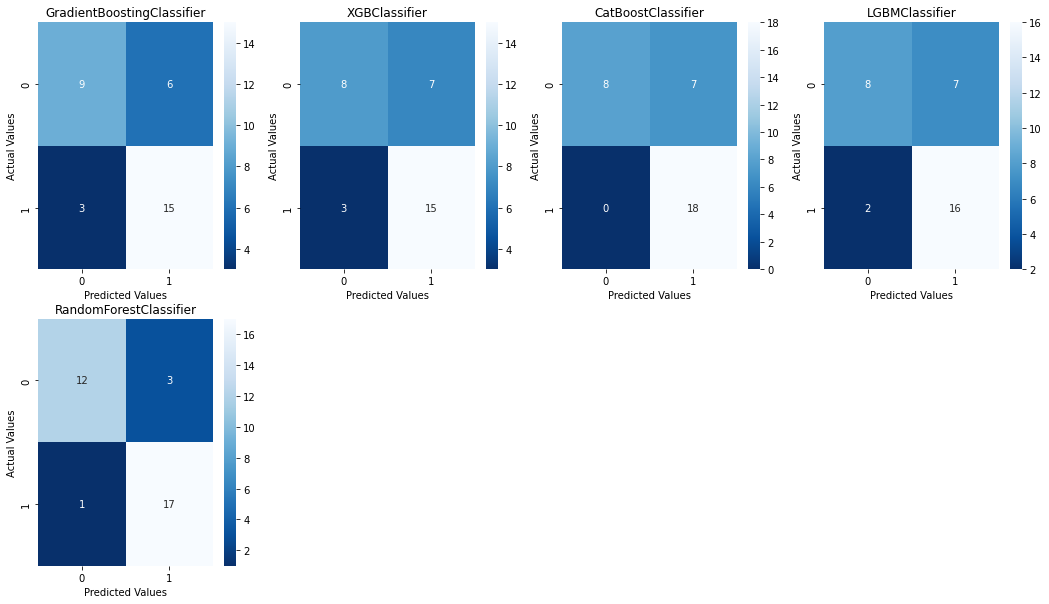

In [24]:
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = gbs_list[i]
    pairplot(cm, model) 

In [25]:
result_TTS_GBS = pd.DataFrame({'Model': gbs_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_TTS_GBS

,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.727273,0.72
1,XGBClassifier,0.696970,0.68
2,CatBoostClassifier,0.787879,0.77
3,LGBMClassifier,0.727273,0.71
4,RandomForestClassifier,0.878788,0.87


## <center> Так как объем данных невелик, то посчитаем метрики качества через кросс-валидацию и kfold

## Кросс-валидация

In [69]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(model_pipeline, every = 1):
    crossval(model)    

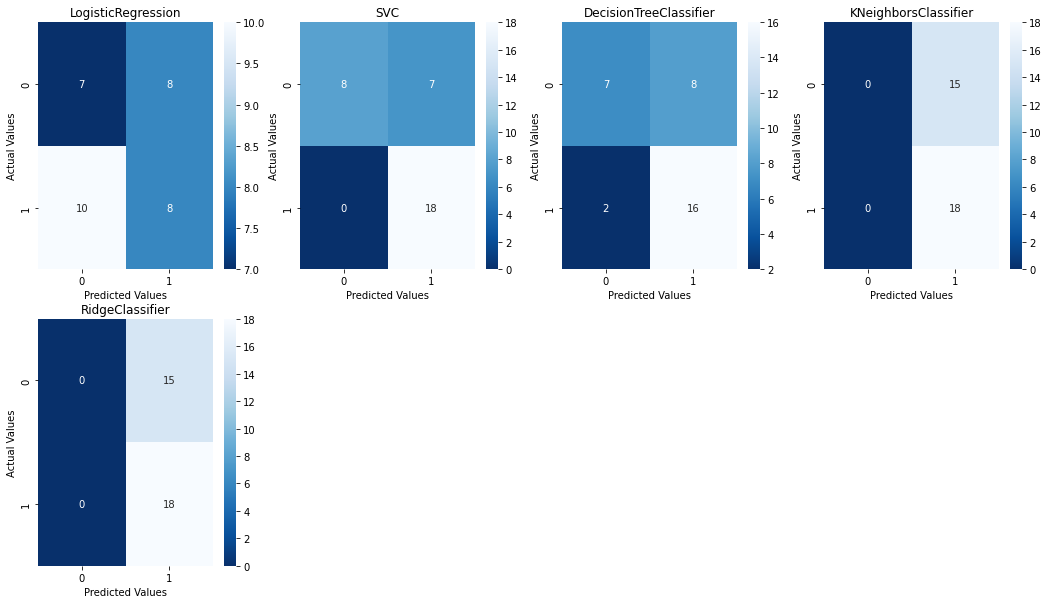

In [70]:
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    pairplot(cm, model)

In [71]:
result_CV_CLS = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_CV_CLS

,Model,Accuracy,AUC
0,LogisticRegression,0.450,0.42
1,SVC,0.800,0.95
2,DecisionTreeClassifier,0.575,0.57
3,KNeighborsClassifier,0.550,0.50
4,RidgeClassifier,0.550,0.35


In [74]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(gbs_pipeline, every = 1):
    crossval(model)

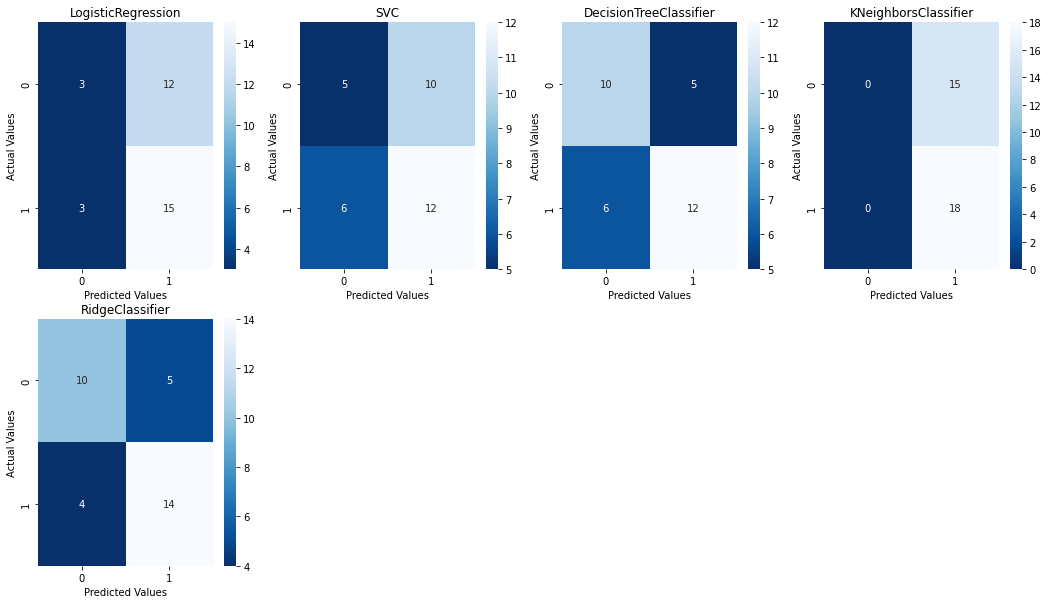

In [75]:
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    pairplot(cm, model)

In [78]:
result_CV_GBS = pd.DataFrame({'Model': gbs_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_CV_GBS

,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.533333,0.60
1,XGBClassifier,0.483333,0.45
2,CatBoostClassifier,0.733333,0.61
3,LGBMClassifier,0.550000,0.50
4,RandomForestClassifier,0.775000,0.68


## K-fold

In [105]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(model_pipeline, every = 1):
    features = wave_features
    label = wave_label
    kf(model)    

In [107]:
result_KF_CLS = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_KF_CLS

,Model,Accuracy,AUC
0,LogisticRegression,0.0,0.00
1,SVC,0.4,0.42
2,DecisionTreeClassifier,0.6,0.67
3,KNeighborsClassifier,0.6,0.50
4,RidgeClassifier,0.4,0.50


In [108]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(gbs_pipeline, every = 1):
    features = wave_features
    label = wave_label
    kf(model)

In [110]:
result_KF_GBS = pd.DataFrame({'Model': gbs_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_KF_GBS

,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.6,0.58
1,XGBClassifier,0.6,0.50
2,CatBoostClassifier,0.2,0.25
3,LGBMClassifier,0.6,0.50
4,RandomForestClassifier,0.6,0.58


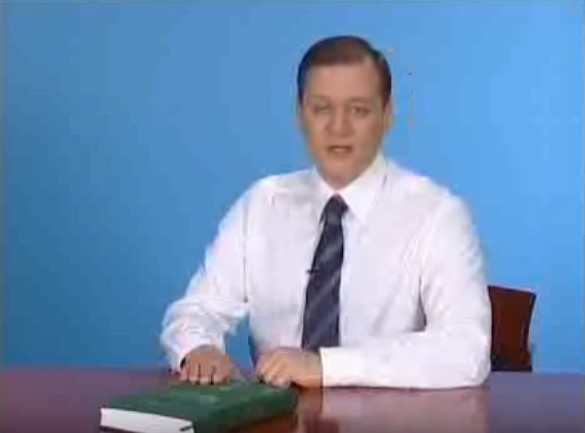

# <center>Часть 2
## <center> Мел-кепстральные коэффициенты (MFCC)

## <center>Создаем датафрейм ~~опять~~

In [111]:
def mel(y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=13)
    log_S = librosa.power_to_db(S, ref=np.max)
    mel_13=librosa.feature.mfcc(S=log_S, n_mfcc=13)
    mfccs = scaler.fit_transform(mel_13)
    data_frame = pd.DataFrame(mfccs.reshape(1,-1))
    all_res.append(data_frame)

In [112]:
all_res = []
scaler = StandardScaler()
for file in os.listdir('Dolphine'):
    y, sr = librosa.load(f'Dolphine\{file}', duration=2)
    mel(y,sr)
data_d = pd.concat(all_res, ignore_index = True)
data_d.insert(0, 'label', 1, True)

In [113]:
all_res = []
scaler = StandardScaler()
for file in os.listdir('Horse'):
    y, sr = librosa.load(f'Horse\{file}', duration=2)
    mel(y,sr)
data_h = pd.concat(all_res, ignore_index = True)
data_h.insert(0, 'label', 0, True)

In [114]:
frames = [data_d, data_h]
data = pd.concat(frames)
list_nan = data.columns[data.isna().any()].tolist()
data = data.iloc[: , :list_nan[0]]
mel_data = data.sample(frac=1).reset_index(drop=True)

In [115]:
mel_data

,label,0,1,2,3,4,5,6,7,8,...,613,614,615,616,617,618,619,620,621,622
0,0,-3.411583,-3.412454,-3.397836,-3.418716,-3.394011,-3.359028,-3.359742,-3.351161,-3.353557,...,0.106933,0.046484,-0.009041,-0.048858,-0.041693,-0.006779,0.044978,-0.021078,-0.128539,-0.249543
1,1,-3.357814,-3.358216,-3.204578,-3.150481,-3.104603,-3.050489,-3.033972,-3.058090,-3.050398,...,1.009834,1.122613,1.126342,1.044989,1.047807,1.107275,1.144395,1.079965,1.075325,1.055262
2,1,-3.417195,-3.406011,-3.405518,-3.402002,-3.395075,-3.401655,-3.403185,-3.403829,-3.359451,...,0.452690,0.413419,0.407709,0.437776,0.392514,0.479220,0.586033,0.652953,0.713607,0.758061
3,1,-3.312926,-3.267963,-3.235956,-3.034081,-2.835028,-2.652731,-2.567953,-2.570692,-2.612303,...,0.567683,0.456285,0.426786,0.450235,0.502544,0.616206,0.718744,0.784631,0.765888,0.741458
4,1,-3.218498,-3.230794,-3.402040,-3.414982,-3.291990,-3.278081,-3.387576,-3.407032,-3.378934,...,0.560389,0.553600,0.498700,0.436135,0.384576,0.357562,0.377780,0.402314,0.270985,0.290821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,-3.329902,-3.290218,-3.358264,-3.376676,-3.366990,-3.367617,-3.332554,-3.180957,-3.106215,...,0.455978,0.453740,0.429336,0.458636,0.501290,0.503277,0.519533,0.651314,0.672918,0.680798
96,0,-3.442812,-3.422187,-3.411391,-3.404582,-3.402639,-3.379929,-3.325942,-3.291456,-3.309528,...,0.201767,0.231595,0.178416,0.198478,0.201036,0.162223,0.168406,0.202666,0.182431,0.164540
97,1,-3.342058,-3.057901,-2.962674,-3.222428,-3.284931,-3.292892,-3.309161,-3.285724,-3.295859,...,0.385500,0.412473,0.394343,0.371328,0.444447,0.485781,0.409561,0.394198,0.402499,0.458731
98,1,-3.430926,-3.420910,-3.422111,-3.427142,-3.396816,-3.325676,-3.253126,-3.192419,-3.101745,...,0.481659,0.560224,0.504565,0.301375,0.095279,0.011159,0.154019,0.242797,0.232408,0.266347


## <center> Сохраним и эти данные

In [44]:
mel_data.to_csv('mel_data.csv', index=False)

## <center>Разделим данные на features и label

In [116]:
mel_label = mel_data['label']
mel_features = mel_data.drop(['label'], axis=1)
mel_label.shape, mel_features.shape

((100,), (100, 623))

## <center> Снизим размерность для отображения

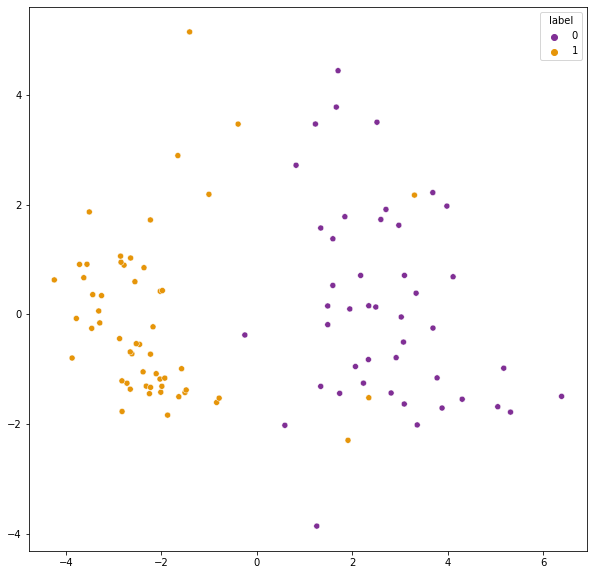

In [117]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(mel_features.to_numpy())
data_scaled = pd.DataFrame(data_scaled)
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=pca_transformed[:, 0], 
    y=pca_transformed[:, 1], 
    hue=mel_label.astype(int), 
    palette="CMRmap",
    legend='full'
);

## <center> Разделяем данные на тест и трэйн

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
    mel_features,
    mel_label,
    test_size=0.33,
    stratify=mel_label,
    random_state=42)

In [145]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(model_pipeline, every = 1):
    tts(model)

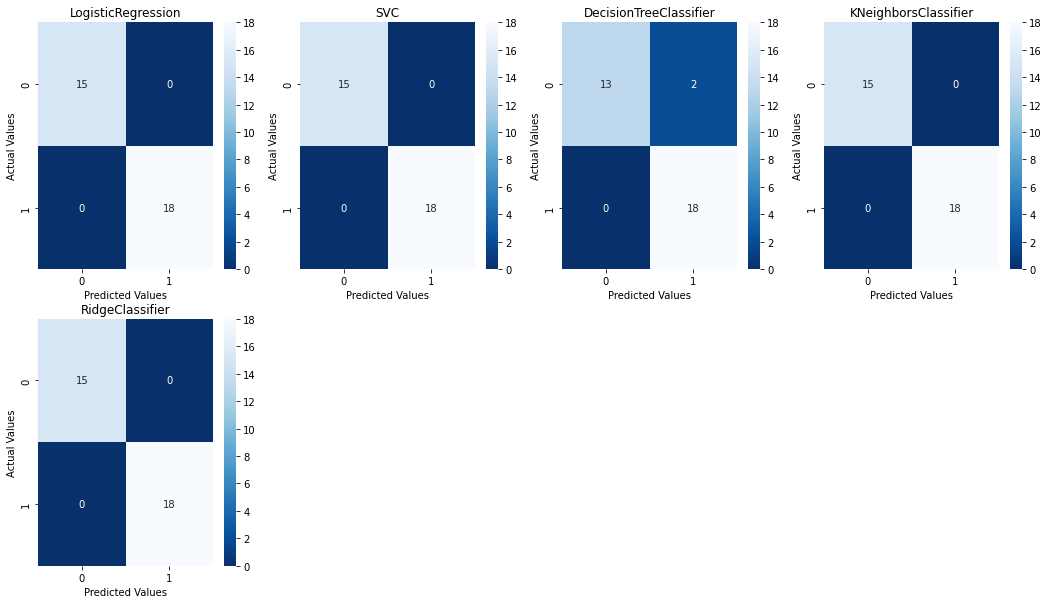

In [146]:
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    pairplot(cm, model)    

In [147]:
MEL_TTS_CLS = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
MEL_TTS_CLS

,Model,Accuracy,AUC
0,LogisticRegression,1.000000,1.00
1,SVC,1.000000,1.00
2,DecisionTreeClassifier,0.939394,0.93
3,KNeighborsClassifier,1.000000,1.00
4,RidgeClassifier,1.000000,1.00


In [121]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(gbs_pipeline, every = 1):
    tts(model)

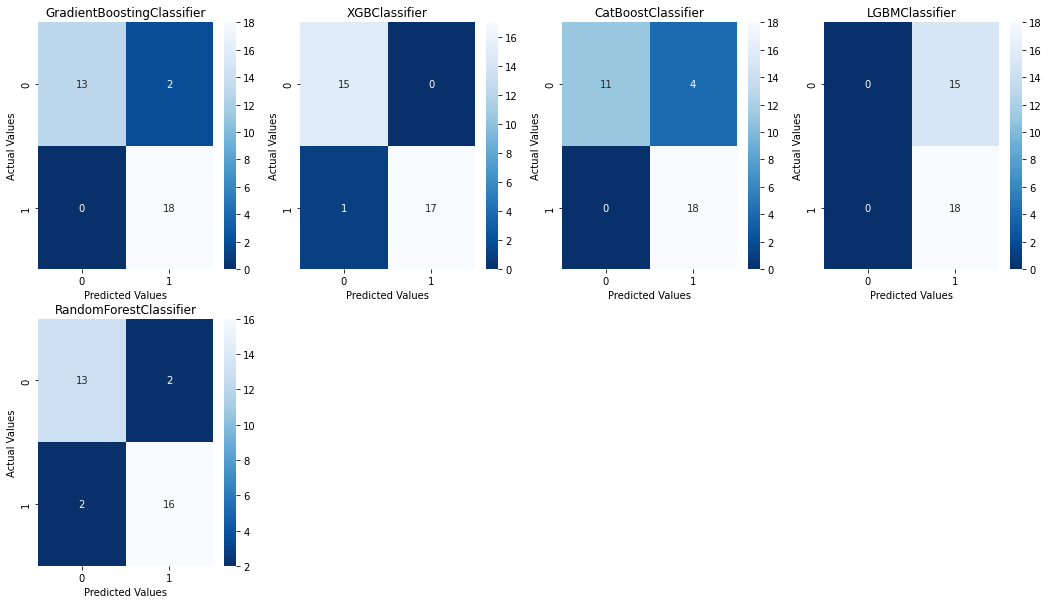

In [122]:
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = gbs_list[i]
    pairplot(cm, model)

In [123]:
MEL_TTS_GBS = pd.DataFrame({'Model': gbs_list, 'Accuracy': acc_list, 'AUC': auc_list})
MEL_TTS_GBS

,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.939394,0.93
1,XGBClassifier,0.969697,0.97
2,CatBoostClassifier,0.878788,0.87
3,LGBMClassifier,0.545455,0.50
4,RandomForestClassifier,0.878788,0.88


## <center> И опять

## Кросс-валидация

In [124]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(model_pipeline, every = 1):
    crossval(model)    

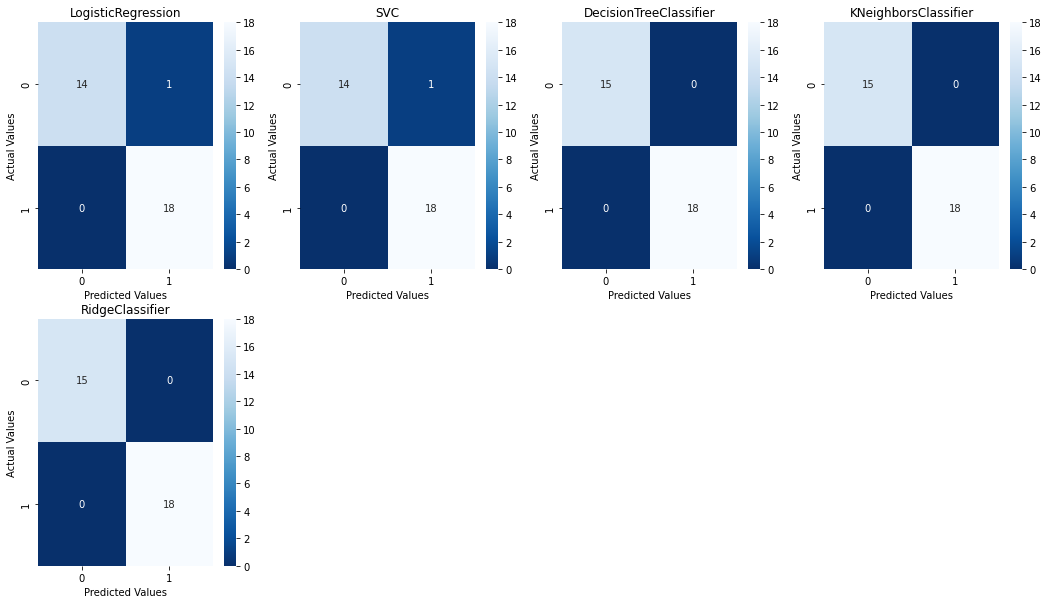

In [125]:
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    pairplot(cm, model)    

In [126]:
MEL_CV_CLS = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
MEL_CV_CLS

,Model,Accuracy,AUC
0,LogisticRegression,0.975,1.00
1,SVC,0.975,1.00
2,DecisionTreeClassifier,0.875,0.98
3,KNeighborsClassifier,1.000,1.00
4,RidgeClassifier,1.000,1.00


In [127]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(gbs_pipeline, every = 1):
    crossval(model)

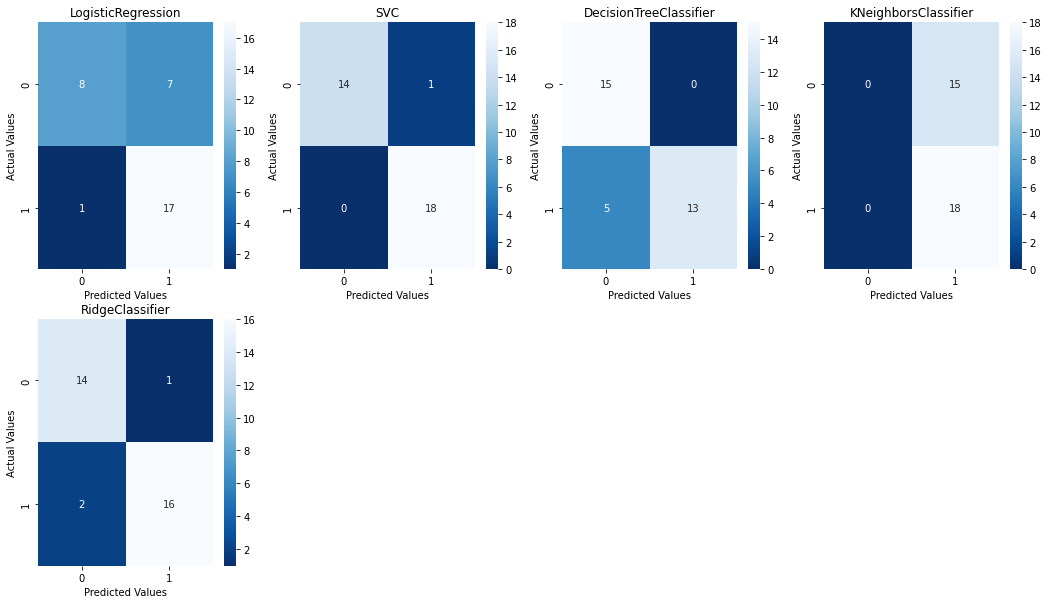

In [128]:
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    pairplot(cm, model)    

In [129]:
MEL_CV_GBS = pd.DataFrame({'Model': gbs_list, 'Accuracy': acc_list, 'AUC': auc_list})
MEL_CV_GBS

,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.783333,0.95
1,XGBClassifier,0.975000,0.98
2,CatBoostClassifier,0.841667,0.96
3,LGBMClassifier,0.550000,0.50
4,RandomForestClassifier,0.825000,0.80


## Kfold

In [160]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(model_pipeline, every = 1):
    feature = mel_features
    label = mel_label
    kf(model)
   

In [161]:
MEL_KF_CLS = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
MEL_KF_CLS

,Model,Accuracy,AUC
0,LogisticRegression,0.50,0.51
1,SVC,0.55,0.50
2,DecisionTreeClassifier,0.50,0.48
3,KNeighborsClassifier,0.35,0.50
4,RidgeClassifier,0.45,0.45


In [151]:
acc_list = []
auc_list = []
cm_list = []
for model in log_progress(gbs_pipeline, every = 1):
    feature = mel_features
    label = mel_label
    kf(model)

In [154]:
MEL_KF_GBS = pd.DataFrame({'Model': gbs_list, 'Accuracy': acc_list, 'AUC': auc_list})
MEL_KF_GBS

,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.500000,0.50
1,XGBClassifier,0.500000,0.50
2,CatBoostClassifier,0.470588,0.44
3,LGBMClassifier,0.529412,0.50
4,RandomForestClassifier,0.588235,0.57


## <center> Подведем итоги

In [172]:
dfs = [result_TTS_CLS, result_TTS_GBS, result_CV_CLS, result_CV_GBS, result_KF_CLS, result_KF_GBS, MEL_TTS_CLS, MEL_TTS_GBS, MEL_CV_CLS, MEL_CV_GBS, MEL_KF_CLS, MEL_KF_GBS]
[display(i) for i in (dfs)]

,Model,Accuracy,AUC
0,LogisticRegression,0.727273,0.72
1,SVC,0.696970,0.68
2,DecisionTreeClassifier,0.787879,0.77
3,KNeighborsClassifier,0.727273,0.71
4,RidgeClassifier,0.848485,0.84


,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.727273,0.72
1,XGBClassifier,0.696970,0.68
2,CatBoostClassifier,0.787879,0.77
3,LGBMClassifier,0.727273,0.71
4,RandomForestClassifier,0.878788,0.87


,Model,Accuracy,AUC
0,LogisticRegression,0.450,0.42
1,SVC,0.800,0.95
2,DecisionTreeClassifier,0.575,0.57
3,KNeighborsClassifier,0.550,0.50
4,RidgeClassifier,0.550,0.35


,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.533333,0.60
1,XGBClassifier,0.483333,0.45
2,CatBoostClassifier,0.733333,0.61
3,LGBMClassifier,0.550000,0.50
4,RandomForestClassifier,0.775000,0.68


,Model,Accuracy,AUC
0,LogisticRegression,0.0,0.00
1,SVC,0.4,0.42
2,DecisionTreeClassifier,0.6,0.67
3,KNeighborsClassifier,0.6,0.50
4,RidgeClassifier,0.4,0.50


,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.6,0.58
1,XGBClassifier,0.6,0.50
2,CatBoostClassifier,0.2,0.25
3,LGBMClassifier,0.6,0.50
4,RandomForestClassifier,0.6,0.58


,Model,Accuracy,AUC
0,LogisticRegression,1.000000,1.00
1,SVC,1.000000,1.00
2,DecisionTreeClassifier,0.939394,0.93
3,KNeighborsClassifier,1.000000,1.00
4,RidgeClassifier,1.000000,1.00


,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.939394,0.93
1,XGBClassifier,0.969697,0.97
2,CatBoostClassifier,0.878788,0.87
3,LGBMClassifier,0.545455,0.50
4,RandomForestClassifier,0.878788,0.88


,Model,Accuracy,AUC
0,LogisticRegression,0.975,1.00
1,SVC,0.975,1.00
2,DecisionTreeClassifier,0.875,0.98
3,KNeighborsClassifier,1.000,1.00
4,RidgeClassifier,1.000,1.00


,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.783333,0.95
1,XGBClassifier,0.975000,0.98
2,CatBoostClassifier,0.841667,0.96
3,LGBMClassifier,0.550000,0.50
4,RandomForestClassifier,0.825000,0.80


,Model,Accuracy,AUC
0,LogisticRegression,0.50,0.51
1,SVC,0.55,0.50
2,DecisionTreeClassifier,0.50,0.48
3,KNeighborsClassifier,0.35,0.50
4,RidgeClassifier,0.45,0.45


,Model,Accuracy,AUC
0,GradientBoostingClassifier,0.500000,0.50
1,XGBClassifier,0.500000,0.50
2,CatBoostClassifier,0.470588,0.44
3,LGBMClassifier,0.529412,0.50
4,RandomForestClassifier,0.588235,0.57


[None, None, None, None, None, None, None, None, None, None, None, None]